## Investigating Concentrated Liquidity and Impermanent Loss

### Goals
- Look at various ranges of price for each token across time and fee collection
- Want to understand how much fees need to be collected to cover the impermanent loss
- Try to figure out the best ranges based on estimates of total price changes

### Questions
- Should the program be able to apply re-balance using geometric mean?
- Should linear regression be used to help find the answers?  Or just look at 3D plots?
- Can look at both compounding and just collecting fees


### Notes
- Don't bother trying to calculate the fees generated based on volume, just figure out what the fees need to be based on the "final" price of the tokens
- Create "high-side" and "low-side" outs and figure out the fees required and and what the APR would need to average given a timeframe that it did stay in the range 
- Then can get fancy and do re-balances, etc.

### Ideas
- Set a future date and then a list of prices and a probability for hitting each one at the end of the period.  Then calculate the difference in impermanent loss assuming you are re-balancing and compounding



In [ ]:
# Look at impermanent loss with a 10% increase 
import core.helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.setup_new_position(seed_usd, 10, 9)
print(lp)
btc.price *= 1.1
lp.update_token_balances(30)
print(lp)


In [ ]:
# Look at IL with a ± 20% range chasing the price
import core.helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.setup_new_position(seed_usd, 10, 10)
price = [1, 1, -1, -1, -1, 1]
for i in price:
    btc.price *= (1 + i/10)
    lp.update_token_balances(30)
    lp.rebalance(10, 10)
print(lp)

In [ ]:
# Loop LP price and duration and check APR required
import numpy as np
import pandas as pd
import core.helper_classes as hc
import matplotlib.pyplot as plt

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)
lp = hc.LiquidityPool(btc, usdc)
lp.setup_new_position(seed_usd, 10, 10)
aprs = []

for price in np.arange(90000, 110000, 1000):
    for duration in np.arange(0, 70, 7):
        btc.price = price
        lp.update_token_balances(duration)
        data = [price, duration, lp.apr]
        aprs.append(data)

data = pd.DataFrame(aprs, columns=['price', 'duration', 'apr'])
print(data)

In [ ]:
# Testers
import core.helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)
eth = hc.Token("ETH", 3600)

lp = hc.LiquidityPool(btc, usdc)
lp.setup_new_position(seed_usd, 10, 15)
print(lp)
lp.token_x.price = 110000
lp.update_token_balances(30)
print(lp)

lp2 = hc.LiquidityPool(eth, btc)
lp2.setup_new_position(seed_usd, 10, 10)
print(lp2)
lp2.token_x.price = 3800
lp2.token_y.price = 110000
lp2.update_token_balances(30)
print(lp2)

In [ ]:
# Test 2
import core.helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.setup_new_position(seed_usd, 10, 10)
print(lp)
btc.price *= 1.05
lp.update_token_balances(10)
print(lp)
lp.coumpound_fees(350)
print(lp)

Coingecko provides historical data using the public API with these restrictions:

You may leave the interval as empty for automatic granularity:
- 1 day from current time = 5-minutely data
- 2 - 90 days from current time = hourly data
- above 90 days from current time = daily data (00:00 UTC)

In [ ]:
# Get historical pricing data
# Keep the historical fetching below 90 days to get hourly based data
import core.helper_classes as hc
import pandas as pd
from datetime import datetime as dt

api_id = 'bitcoin'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
btc_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

api_id = 'ethereum'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
eth_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

api_id = 'solana'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
sol_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

Getting historical in_data for bitcoin
Try #1
Getting historical in_data for ethereum
Try #1
Getting historical in_data for solana
Try #1


In [36]:
# Use Weiner process to get future price predictions
lookback_days = 30  # Decide how much historical data to use for prediciton input
lookback_hours = lookback_days * 24

data = btc_data.copy().tail(lookback_hours)
data['gain'] = data['price'].pct_change()
mean_gain = data['gain'].mean()
std_gain = data['gain'].std()

btc = hc.Token("BTC", 106500)
iterations = 10000
predict_days = 15
predict_hours = predict_days * 24
b = hc.Brownian()
predict = []
for i in range(iterations):
    x = b.stock_price(btc.price, mean_gain, std_gain, predict_hours, 1)
    predict.append(x)
df = pd.DataFrame(predict).T


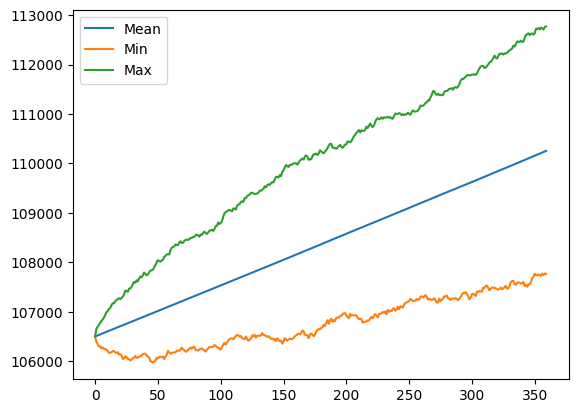

In [37]:
# Look at price prediction over time
import matplotlib.pyplot as plt

mean_price = df.mean(axis=1)
min_price = df.min(axis=1)
max_price = df.max(axis=1)
std_price = df.std(axis=1)

plt.plot(df.index, mean_price, label='Mean')
plt.plot(df.index, min_price, label='Min')
plt.plot(df.index, max_price, label='Max')
plt.legend()
plt.show()

<Axes: >

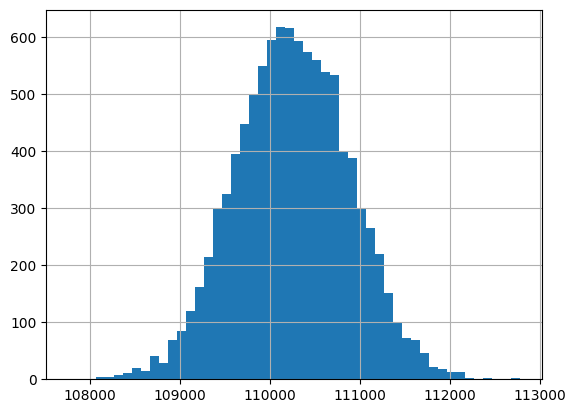

In [38]:
# Look at distribution of final price
end = df.iloc[-1]
end.hist(bins=50)

In [39]:
# Calculate IL for each price case and look at the 95th percentile value
btc = hc.Token("BTC", 106500)
usdc = hc.Token("USDC", 1)
lp = hc.LiquidityPool(btc, usdc)
seed_usd = 10000
lp.setup_new_position(seed_usd, 7, 7)
il = []
for idx, val in end.items():
    btc.price = val
    lp.update_token_balances(predict_days)
    il.append(lp.impermanent_loss)
result = pd.Series(il)
for pct in [50, 90, 95, 99]:
    print(f"{pct}th percentile Impermanent Loss = ${result.quantile(pct/100):.2f}")
    apy = result.quantile(pct/100) / seed_usd * 100 * (365 / predict_days)
    # compound once per week
    compound_period = int(predict_days / 7)
    apr = hc.apy_to_apr(apy, compound_period)
    print(f"{pct}th percentile APR Required (compounded weekly) = {apr:.1f}%")
    apr_day = hc.apy_to_apr(apy, predict_days)
    print(f"{pct}th percentile APR Required (compounded daily) = {apr_day:.1f}%\n")

50th percentile Impermanent Loss = $220.55
50th percentile APR Required (compounded weekly) = 47.9%
50th percentile APR Required (compounded daily) = 43.6%

90th percentile Impermanent Loss = $280.41
90th percentile APR Required (compounded weekly) = 59.4%
90th percentile APR Required (compounded daily) = 52.9%

95th percentile Impermanent Loss = $296.26
95th percentile APR Required (compounded weekly) = 62.4%
95th percentile APR Required (compounded daily) = 55.3%

99th percentile Impermanent Loss = $329.83
99th percentile APR Required (compounded weekly) = 68.5%
99th percentile APR Required (compounded daily) = 60.1%



## Other Thoughts

* Look at re-balancing vs not given a certain APR
* Can estimate the liquidity by looking at the average APR over as long a period as possible and distributing that across the liquidity
* best way to do this is build a sub-graph, but there should be a reasonable way to estimate it.  The point is just to look at re-balance vs not.  Both geometric and chasing.

In [ ]:
import core.helper_classes as hc
import unimath as um
# cbBTC/USDC Farm Statistics on Aerodrome
tvl_total = 9160644
tvl_active = 7418151
tvl_rewarded = 433085
weekly_rewards = 436271
pct_rewarded = tvl_rewarded / tvl_active
fee_tier = 0.005
tick_spacing = 100  # This represents a 1% change per tick so:
pct_per_tick = tick_spacing / 100
# Concentrated APRs (Can use as a good estimate)  
# TODO: Eventually can pull this from the blockchain
two_ticks = 2293
four_ticks = 1146
six_ticks = 764
twelve_ticks = 382
twenty_ticks = 229
# I now know the percentatges, but want to figure this over the weekly reward amount for a better average
# Actually, I can use the weekly rewards over the tvl_rewarded and find the APR per tick and then divide that based on the number of ticks
apr_per_tick = weekly_rewards / tvl_rewarded * 52
# So all I really need is the rewarded tvl, weekly rewards, and the percent per tick (from tick spacing)


In [9]:
# Simplifying the Above
# cbBTC/USDC Farm stats on Aerodrome
weekly_rewards = 436271
tvl_rewarded = 433085
apr_per_tick = weekly_rewards / tvl_rewarded * 52 * 100
print(f'Average APR per tick: {apr_per_tick:.2f}%')

Average APR per tick: 5238.25%


In [ ]:
import core.helper_classes as hc
# Apply to LP
btc = hc.Token("BTC", 105000)
usdc = hc.Token("USDC", 1)
lp = hc.LiquidityPool(btc, usdc)
seed_usd = 10000
fee_per_day_per_tick = apr_per_tick / 100 / 365 * seed_usd
low_range = 7
high_range = 7
lp.setup_new_position(seed_usd, low_range, high_range)
print(lp)
fee_per_day = fee_per_day_per_tick / (low_range + high_range)
btc.price = 100000
lp.fees_accrued += fee_per_day * 7
lp.coumpound_fees_accured()
lp.update_token_balances(7)

print(lp)

BTC: 0.047462 ($4983.53)| USDC: 5010.706638 ($5010.71)
LP Value: $9994.24
Current Price: 105000.000000 in USDC/BTC
Ticks (low, current, high) 114921, 115622, 116321
Range: 97882.732431 ~ 112591.154388
Hold Value: $9994.24
Impermanent Loss: $0.00
Fee APR required to offset IL: 0.0%
Fees Accrued: $0.00
Total Fees: $0.00

BTC: 0.092910 ($9291.03)| USDC: 1717.554618 ($1717.55)
LP Value: $11008.59
Current Price: 100000.000000 in USDC/BTC
Ticks (low, current, high) 114921, 115135, 116321
Range: 97882.732431 ~ 112591.154388
Hold Value: $9518.32
Impermanent Loss: $-1490.27
Fee APR required to offset IL: 0.0%
Fees Accrued: $0.00
Total Fees: $717.57

